In [1]:
import sys
sys.path.append('../../')
import cresthh
from cresthh import anuga
from osgeo import gdal
from glob import glob
from affine import Affine
import geopandas as gpd
from pyproj import Proj, CRS, transform


%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

In [2]:
bounding_polygon= gpd.read_file('watershed_shp/watershed.shp')
# bounding_polygon= gpd.read_file('area/domain.shp')
# Elevation Data
# topography_file = 'DEM.tif'
topography_file = 'DEM_filled.tif'
# topography_file= '/home/ZhiLi/CRESTHH/data/precip/imerg20170825S150000.tif'

# Resolution for most of the mesh
base_resolution = 10  # m^2


In [3]:
# lons= np.array(bounding_polygon.exterior[0].coords)[:,0]; lats=np.array(bounding_polygon.exterior[0].coords)[:,1]
lons= np.array(bounding_polygon.exterior[1].coords)[:,0]; lats=np.array(bounding_polygon.exterior[1].coords)[:,1]

In [4]:
myProj = Proj("+proj=utm +zone=15, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [5]:
utm_coords= [myProj(lon,lat) for (lon, lat) in zip(lons, lats)]

Figure files for each frame will be stored in _plot


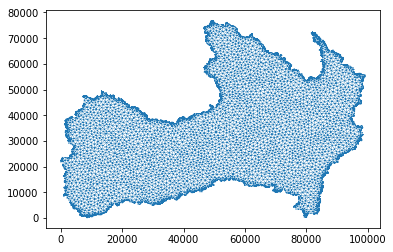

In [6]:
domain = anuga.create_domain_from_regions(
            utm_coords,
            boundary_tags={'bottom': [0]},
            maximum_triangle_area=1000000,
            
            )

# domain= anuga.create_domain_from_rectangular()

# Basic geometry and bounding polygon
# xleft   = -95.05
# xright  = -95.83
# ybottom = 29.79
# ytop    = 30.18

# point_sw = [xleft, ybottom]
# point_se = [xright, ybottom]
# point_nw = [xleft, ytop]    
# point_ne = [xright, ytop]

# bounding_polygon = [point_se,
#                     point_ne,
#                     point_nw,
#                     point_sw]



# domain= anuga.create_domain_from_regions(bounding_polygon,boundary_tags={'bottom': [0],},maximum_triangle_area=0.0005)

# domain= anuga.rectangular_cross_domain

domain.set_name('excessive_rain') # Name of sww file
dplotter = anuga.Domain_plotter(domain)  
plt.triplot(dplotter.triang, linewidth = 0.4);

In [9]:
print 'Number of elements:',domain.number_of_elements

Number of elements: 10203


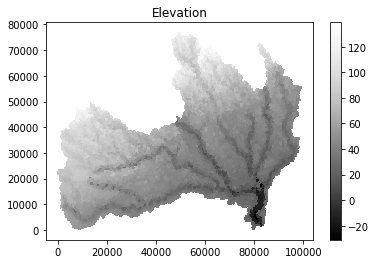

In [10]:
domain.set_proj("+proj=utm +zone=15, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
domain.set_quantity('elevation', filename=topography_file, location='centroids') # Use function for elevation
domain.set_quantity('friction', 0.03, location='centroids')                        # Constant friction 
domain.set_quantity('stage', expression='elevation', location='centroids')         # Dry Bed 
domain.set_quantity('SS0', 0, location='centroids')
domain.set_quantity('SI0', 0, location='centroids')
domain.set_quantity('W0', 0, location='centroids')
domain.set_quantity('RainFact', 0.5, location='centroids')
domain.set_quantity('Ksat', 0.5, location='centroids')
domain.set_quantity('WM', 0.5, location='centroids')
domain.set_quantity('B', 0.5, location='centroids')
domain.set_quantity('IM', 0.5, location='centroids')
domain.set_quantity('KE', 0.5, location='centroids')
domain.set_quantity('coeM', 0.5, location='centroids')
domain.set_quantity('expM', 0.5, location='centroids')
domain.set_quantity('coeR', 0.5, location='centroids')
domain.set_quantity('coeS', 0.5, location='centroids')
domain.set_quantity('KS', 0.5, location='centroids')
domain.set_quantity('KI', 0.5, location='centroids')
domain.set_evap_dir('/home/ZhiLi/CRESTHH/data/evap', pattern='cov_et17%m%d.asc.tif', freq='1D')
# domain.set_precip_dir('/home/ZhiLi/CRESTHH/data/precip',pattern='nimerg%Y%m%dS%H%M%S.tif', freq='1H')
domain.set_precip_dir('/hydros/MengyuChen/mrmsPrecRate',pattern='PrecipRate_00.00_%Y%m%d-%H%M00.grib2-var0-z0.tif', freq='1H')
domain.set_timestamp('20170826050000', format='%Y%m%d%H%M%S')
domain.set_time_interval('1H')
total_seconds= (pd.to_datetime('20170901000000') - pd.to_datetime('20170826050000')).total_seconds()

plt.tripcolor(dplotter.triang, 
              facecolors = dplotter.elev, 
              cmap='Greys_r')
plt.colorbar();
plt.title("Elevation");

In [11]:
Br = anuga.Reflective_boundary(domain)
Bt = anuga.Transmissive_boundary(domain)
Bi = anuga.Dirichlet_boundary([0, 0, 0]) 

domain.set_boundary({'bottom':   Bt,
                     'exterior': Bi})

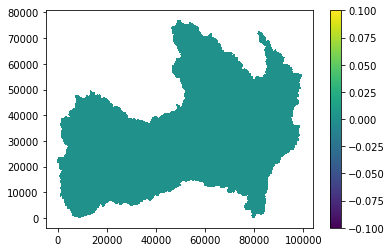

In [12]:
domain.quantities['xvelocity'].plot_quantity()

In [13]:
# Rain = anuga.Quantity(domain, name='Rain')
# ET= anuga.Quantity(domain, name='ET')
# forcing_op= anuga.Rate_operator(domain, rate=Rain+ET)
# rain_op = anuga.Rate_operator(domain, rate = Rain)
# et_op = anuga.Rate_operator(domain, rate= Evap)
# Rain= anuga.Rate_operator(domain, rate=lambda t: 5 if t<5 else 10)
for i,t in enumerate(domain.evolve(yieldstep=3600, duration=total_seconds)):
#     current_rain_file = sorted(glob(external_dir+'/*.tif'))[i]
#     print(current_rain_file)
#     Rain.set_values_from_utm_grid_file(current_rain_file, location='centroids')
#     ET.set_values_from_utm_grid_file(current_rain_file, location='centroids')
#     dplotter.plot_depth_frame()
    dplotter.save_depth_frame(vmin=0, vmax=10)
#     domain.print_operator_timestepping_statistics()
    domain.print_timestepping_statistics()
#     domain.report_water_volume_statistics()

    stage = domain.get_quantity('stage')
    elev  = domain.get_quantity('elevation')
    height = stage - elev
    print 'integral = ', height.get_integral()    
# Read in the png files stored during the evolve loop
dplotter.make_depth_animation() 

evolving elements: 10203
Time = 2017-08-26 05:00:00, steps=0 (2s)
integral =  0.0
Time = 2017-08-26 06:00:00, delta t in [1.81381269, 2.44830744], steps=1489 (8s)
integral =  10296106.19783117
Time = 2017-08-26 07:00:00, delta t in [2.42817979, 2.42817981], steps=1483 (8s)
integral =  18217166.856175907
Time = 2017-08-26 08:00:00, delta t in [2.42817979, 2.42817982], steps=1483 (8s)
integral =  26236921.88000329
Time = 2017-08-26 09:00:00, delta t in [2.42817977, 2.42817979], steps=1483 (8s)
integral =  33946785.33050026
Time = 2017-08-26 10:00:00, delta t in [2.42817870, 2.42818371], steps=1483 (8s)
integral =  42390806.087979436
Time = 2017-08-26 11:00:00, delta t in [2.42818214, 2.42818425], steps=1483 (8s)
integral =  51920508.99138647
Time = 2017-08-26 12:00:00, delta t in [2.42818101, 2.42818246], steps=1483 (8s)
integral =  64004651.581410825
Time = 2017-08-26 13:00:00, delta t in [2.42818046, 2.42818115], steps=1483 (8s)
integral =  81707578.58836116
Time = 2017-08-26 14:00:00,

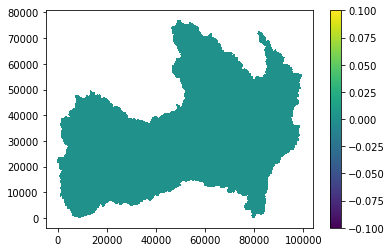

In [22]:
domain.quantities['xvelocity'].plot_quantity()

In [18]:
# from matplotlib import animation
# ani= dplotter.make_depth_animation()
# mywriter = animation.FFMpegWriter(fps=1)
# ani.save('/home/ZhiLi/myanimation.gif')
